In [199]:
# The question: How many deaths can be predicted by vaccination rates?
# The strategy: regress death rates onto last weeks and the current weeks vaccination rates
# Result - L1 estimate: 200k deaths. 25th, 75th quantile confidence interval [50k, 570k]. NOT SIGNIFICANT with at alpha=0.05  
# Data source: CDC (see README.md)
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")

In [200]:
# Make a convenience function that transforms state codes to state names

#'x' is the column of a data.frame that holds 2 digit state codes
stateFromLower <-function(x) {
   #read 52 state codes into local variable [includes DC (Washington D.C. and PR (Puerto Rico)]
  st.codes<-data.frame(
                      state=as.factor(c("AK", "AL", "AR", "AZ", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
                                         "HI", "IA", "ID", "IL", "IN", "KS", "KY", "LA", "MA", "MD", "ME",
                                         "MI", "MN", "MO", "MS",  "MT", "NC", "ND", "NE", "NH", "NJ", "NM",
                                         "NV", "NY", "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN",
                                         "TX", "UT", "VA", "VT", "WA", "WI", "WV", "WY")),
                      full=as.factor(c("alaska","alabama","arkansas","arizona","california","colorado",
                                       "connecticut","district of columbia","delaware","florida","georgia",
                                       "hawaii","iowa","idaho","illinois","indiana","kansas","kentucky",
                                       "louisiana","massachusetts","maryland","maine","michigan","minnesota",
                                       "missouri","mississippi","montana","north carolina","north dakota",
                                       "nebraska","new hampshire","new jersey","new mexico","nevada",
                                       "new york","ohio","oklahoma","oregon","pennsylvania","puerto rico",
                                       "rhode island","south carolina","south dakota","tennessee","texas",
                                       "utah","virginia","vermont","washington","wisconsin",
                                       "west virginia","wyoming"))
                       )
     #create an nx1 data.frame of state codes from source column
  st.x<-data.frame(state=x)
     #match source codes with codes from 'st.codes' local variable and use to return the full state name
  refac.x<-st.codes$full[match(st.x$state,st.codes$state)]
     #return the full state names in the same order in which they appeared in the original source
  return(refac.x)
 
}

# Sum the last k values of a vector with a weight inversely proportional to the number of time points lagged
# E.g. 1/3 + 1/2 + 1, renormalized to sum to 1.
sum_last_k = function(values, k) {
    n = length(values)
    time_kernel = diag(n)
    while (k > 0) {
        time_kernel = time_kernel + rbind(matrix(0, k, n), diag(n)[1:(n-k),]) / k
        k = k - 1
    } 
    time_kernel = t(apply(time_kernel, 1, function(x) x / sum(x)))
    time_kernel
    as.numeric(time_kernel %*% values)
}

In [201]:
# Read death data. Deaths are centered by weekly median from 2014-2019 after a linear trend is 
# removed based on the same time period (see the notebook named "statewide")
deaths = read.csv("../data/state_centered.csv")
deaths$Week.Ending.Date = ymd(deaths$Week.Ending.Date)
head(deaths)
dim(deaths)

,X,State,flu_like_deaths,detrended,detrended_flu_like,median,median_flu_like,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week,centered,centered_flu_like
,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>,<chr>,<int>,<dbl>,<dbl>
1,1,Alabama,38,1057.0000,38,1067.139,33.5,2014-01-04,1057,2014-2019,1,-10.139241,4.5
2,2,Alabama,37,1076.7215,37,1081.361,35.0,2014-01-11,1077,2014-2019,2,-4.639241,2.0
3,3,Alabama,34,1047.4430,34,1034.222,32.5,2014-01-18,1048,2014-2019,3,13.221519,1.5
4,4,Alabama,42,1021.1646,42,1005.544,23.0,2014-01-25,1022,2014-2019,4,15.620253,19.0
5,5,Alabama,26,1039.8861,26,1056.266,23.5,2014-02-01,1041,2014-2019,5,-16.379747,2.5
6,6,Alabama,31,990.6076,31,1035.886,31.5,2014-02-08,992,2014-2019,6,-45.278481,-0.5


[1] 22518    13

In [202]:
# Take in raw vaccination data from the CDC
us_vacc = read.csv("../data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv")
us_vacc$Date = mdy(us_vacc$Date)
us_vacc$year = year(us_vacc$Date)
colnames(us_vacc)

[1] "Date"                                  
 [2] "MMWR_week"                             
 [3] "Location"                              
 [4] "Distributed"                           
 [5] "Distributed_Janssen"                   
 [6] "Distributed_Moderna"                   
 [7] "Distributed_Pfizer"                    
 [8] "Distributed_Unk_Manuf"                 
 [9] "Dist_Per_100K"                         
[10] "Distributed_Per_100k_12Plus"           
[11] "Distributed_Per_100k_18Plus"           
[12] "Distributed_Per_100k_65Plus"           
[13] "Administered"                          
[14] "Administered_12Plus"                   
[15] "Administered_18Plus"                   
[16] "Administered_65Plus"                   
[17] "Administered_Janssen"                  
[18] "Administered_Moderna"                  
[19] "Administered_Pfizer"                   
[20] "Administered_Unk_Manuf"                
[21] "Admin_Per_100K"                        
[22] "Admin_Per_100k_12Plus"                 
[23] "Admin_Per_100k_18Plus"                 
[24] "Admin_Per_100k_65Plus"                 
[25] "Recip_Administered"                    
[26] "Administered_Dose1_Recip"              
[27] "Administered_Dose1_Pop_Pct"            
[28] "Administered_Dose1_Recip_12Plus"       
[29] "Administered_Dose1_Recip_12PlusPop_Pct"
[30] "Administered_Dose1_Recip_18Plus"       
[31] "Administered_Dose1_Recip_18PlusPop_Pct"
[32] "Administered_Dose1_Recip_65Plus"       
[33] "Administered_Dose1_Recip_65PlusPop_Pct"
[34] "Series_Complete_Yes"                   
[35] "Series_Complete_Pop_Pct"               
[36] "Series_Complete_12Plus"                
[37] "Series_Complete_12PlusPop_Pct"         
[38] "Series_Complete_18Plus"                
[39] "Series_Complete_18PlusPop_Pct"         
[40] "Series_Complete_65Plus"                
[41] "Series_Complete_65PlusPop_Pct"         
[42] "Series_Complete_Janssen"               
[43] "Series_Complete_Moderna"               
[44] "Series_Complete_Pfizer"                
[45] "Series_Complete_Unk_Manuf"             
[46] "Series_Complete_Janssen_12Plus"        
[47] "Series_Complete_Moderna_12Plus"        
[48] "Series_Complete_Pfizer_12Plus"         
[49] "Series_Complete_Unk_Manuf_12Plus"      
[50] "Series_Complete_Janssen_18Plus"        
[51] "Series_Complete_Moderna_18Plus"        
[52] "Series_Complete_Pfizer_18Plus"         
[53] "Series_Complete_Unk_Manuf_18Plus"      
[54] "Series_Complete_Janssen_65Plus"        
[55] "Series_Complete_Moderna_65Plus"        
[56] "Series_Complete_Pfizer_65Plus"         
[57] "Series_Complete_Unk_Manuf_65Plus"      
[58] "Additional_Doses"                      
[59] "Additional_Doses_Vax_Pct"              
[60] "Additional_Doses_18Plus"               
[61] "Additional_Doses_18Plus_Vax_Pct"       
[62] "Additional_Doses_50Plus"               
[63] "Additional_Doses_50Plus_Vax_Pct"       
[64] "Additional_Doses_65Plus"               
[65] "Additional_Doses_65Plus_Vax_Pct"       
[66] "Additional_Doses_Moderna"              
[67] "Additional_Doses_Pfizer"               
[68] "Additional_Doses_Janssen"              
[69] "Additional_Doses_Unk_Manuf"            
[70] "Administered_Dose1_Recip_5Plus"        
[71] "Administered_Dose1_Recip_5PlusPop_Pct" 
[72] "Series_Complete_5Plus"                 
[73] "Series_Complete_5PlusPop_Pct"          
[74] "Administered_5Plus"                    
[75] "Admin_Per_100k_5Plus"                  
[76] "Distributed_Per_100k_5Plus"            
[77] "Series_Complete_Moderna_5Plus"         
[78] "Series_Complete_Pfizer_5Plus"          
[79] "Series_Complete_Janssen_5Plus"         
[80] "Series_Complete_Unk_Manuf_5Plus"       
[81] "year"

In [203]:
# Group by week and state and sum total vaccinated
vacc_weekly = us_vacc %>% group_by(MMWR_week, year, Location) %>% summarise(
    Administered_12Plus = sum(Administered_12Plus),
    Admin_Per_100k_12Plus = sum(Admin_Per_100k_12Plus),
    Administered = sum(Administered),
    Admin_Per_100K = sum(Admin_Per_100K),
    Date = max(Date))
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
vacc_weekly = vacc_weekly[!is.na(vacc_weekly$State),]
head(vacc_weekly)                                                           
                                                                            

`summarise()` has grouped output by 'MMWR_week', 'year'. You can override using the `.groups` argument.



MMWR_week,year,Location,Administered_12Plus,Admin_Per_100k_12Plus,Administered,Admin_Per_100K,Date,State
<int>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<int>,<date>,<fct>
0,2022,AK,1998934,328298,2052994,280638,2022-01-02,alaska
0,2022,AL,11198202,267460,11310632,230680,2022-01-02,alabama
0,2022,AR,7465318,291928,7600836,251866,2022-01-02,arkansas
0,2022,AZ,20624566,332330,21053178,289242,2022-01-02,arizona
0,2022,CA,129119104,383754,132464330,335248,2022-01-02,california
0,2022,CO,18545650,375718,19095446,331590,2022-01-02,colorado


In [204]:
# Compute predictors, in this case last week's and the current week's vaccination rates
vacc_weekly$l_Administered_12Plus = 0 
vacc_weekly$l_Administered = 0 
vacc_weekly$l2_Administered = 0 
vacc_weekly$l3_Administered = 0 
vacc_weekly$l4_Administered = 0 
vacc_weekly$l5_Administered = 0 
vacc_weekly$l_Admin_Per_100K = 0 
vacc_weekly$l_Admin_Per_100k_12Plus = 0 
vacc_weekly$l2_Administered = 0 
vacc_weekly$l15_Administered = 0 

for (state in unique(vacc_weekly$Location)) {
    sorted = vacc_weekly[order(vacc_weekly$Date),]
    sorted = subset(sorted, Location == state)
    n = dim(sorted)[1]
    d_admin = diff(sorted$Administered)
    sorted$l_Admin_Per_100K = c(0, diff(sorted$Admin_Per_100K))
    sorted$l_Administered_12Plus = c(0, diff(sorted$Administered_12Plus))
    sorted$l_Administered = c(0, d_admin)
    sorted$l2_Administered = c(0, 0, d_admin[1:(n-2)])
    sorted$l3_Administered = c(0, 0, 0, d_admin[1:(n-3)])
    sorted$l4_Administered = c(0, 0, 0, 0, d_admin[1:(n-4)])
    sorted$l5_Administered = c(0, 0, 0, 0, 0, d_admin[1:(n-5)])
#     sorted$l15_Administered = sum_last_k(c(0, diff(sorted$Administered)), 5)
    vacc_weekly[vacc_weekly$Location == state, ] = sorted
}
vacc_weekly = vacc_weekly[vacc_weekly$Date < ymd("2021-12-15"),]
vacc_weekly = vacc_weekly[(vacc_weekly$l_Administered >= 0) & vacc_weekly$l2_Administered >=0 & vacc_weekly$l3_Administered >= 0 & vacc_weekly$l4_Administered >= 0,]
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
head(vacc_weekly[vacc_weekly$Location == "CA" & year(vacc_weekly$Date) == 2021, 
                 c("Date", "Administered", "l_Administered")])


Date,Administered,l_Administered
<date>,<dbl>,<dbl>
2021-01-30,18310003,7164655
2021-02-06,25735803,7425800
2021-02-13,34948324,9212521
2021-02-20,45051686,10103362
2021-02-27,55603860,10552174
2021-03-06,67502123,11898263


In [205]:
deaths$State = tolower(deaths$State)
sum_deaths = deaths %>% group_by(State) %>% summarize(sum=sum(Total.Deaths))
big_states = tail(sum_deaths[order(sum_deaths$sum),], 7)$State # US is one of these
small_states = head(sum_deaths[order(sum_deaths$sum),], 7)$State
big_states

[1] "illinois"      "ohio"          "pennsylvania"  "florida"      
[5] "texas"         "california"    "united states"

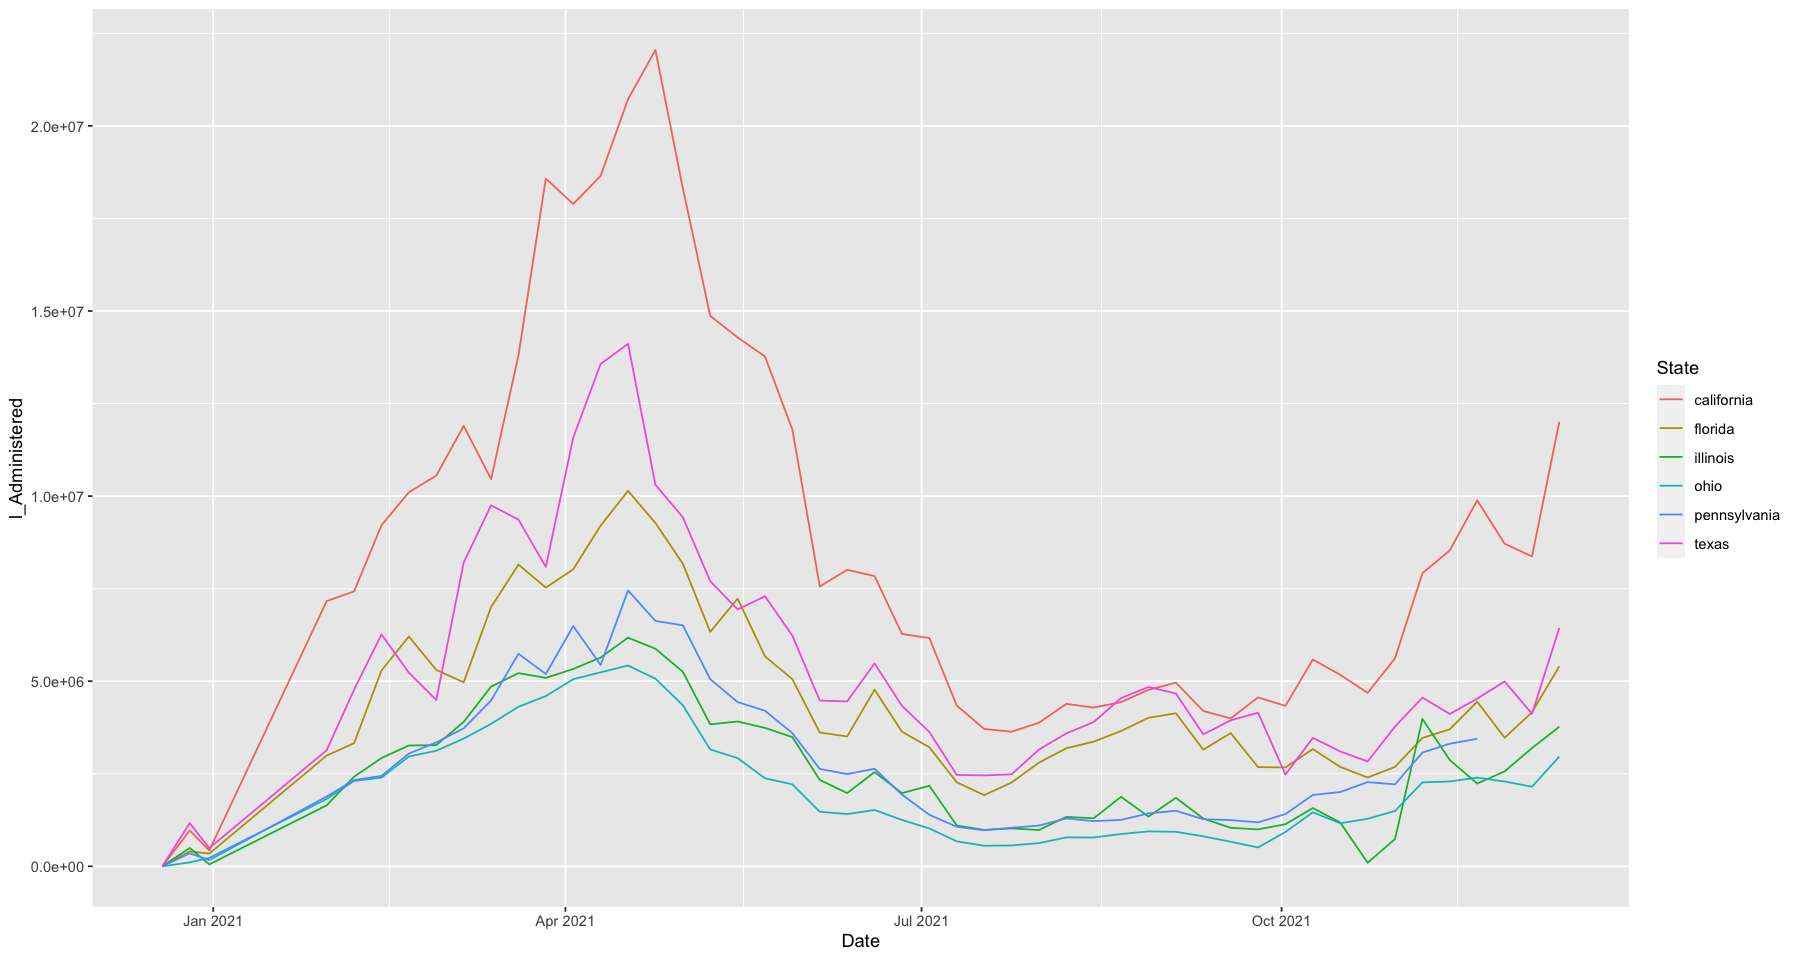

In [206]:
# Plot vaccination rates in select states and remove negative rates (not possible)
a = ggplot(vacc_weekly[vacc_weekly$State %in% big_states,], aes(x=Date, y=l_Administered, color=State))
a + geom_line()

In [221]:

deaths$Date = deaths$Week.Ending.Date
vacc_weekly$State = stateFromLower(vacc_weekly$Location)
df = merge(deaths, vacc_weekly, by = c("Date", "State"))


In [222]:
# Fit a regression with all lags (weeks before death)
lmfit = lm(centered ~ l_Administered + l2_Administered + l3_Administered + l4_Administered + l5_Administered - 1, data=df)
rqfit = rq(centered ~ l_Administered + l2_Administered + l3_Administered + l4_Administered + l5_Administered - 1, data=df)
summary(lmfit)
summary(rqfit)


Call:
lm(formula = centered ~ l_Administered + l2_Administered + l3_Administered + 
    l4_Administered + l5_Administered - 1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1725.1   -24.7    26.3   118.8  4704.7 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
l_Administered   1.036e-04  1.627e-05   6.365 2.32e-10 ***
l2_Administered -4.635e-06  2.586e-05  -0.179  0.85777    
l3_Administered -2.323e-05  2.682e-05  -0.866  0.38657    
l4_Administered  4.001e-05  2.557e-05   1.565  0.11771    
l5_Administered -4.791e-05  1.610e-05  -2.976  0.00295 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 348.7 on 2463 degrees of freedom
Multiple R-squared:  0.1948,	Adjusted R-squared:  0.1931 
F-statistic: 119.2 on 5 and 2463 DF,  p-value: < 2.2e-16


Warning message in summary.rq(rqfit):
“88 non-positive fis”



Call: rq(formula = centered ~ l_Administered + l2_Administered + l3_Administered + 
    l4_Administered + l5_Administered - 1, data = df)

tau: [1] 0.5

Coefficients:
                Value    Std. Error t value  Pr(>|t|)
l_Administered   0.00008  0.00002    4.95662  0.00000
l2_Administered -0.00002  0.00002   -1.23166  0.21819
l3_Administered  0.00000  0.00002   -0.03959  0.96843
l4_Administered  0.00000  0.00002    0.10343  0.91763
l5_Administered  0.00000  0.00001   -0.37229  0.70971

In [223]:
df$non_flu_like = df$centered - df$centered_flu_like
head(df)
dim(df)


,Date,State,X,flu_like_deaths,detrended,detrended_flu_like,median,median_flu_like,Week.Ending.Date,Total.Deaths,⋯,l_Administered_12Plus,l_Administered,l2_Administered,l3_Administered,l4_Administered,l5_Administered,l_Admin_Per_100K,l_Admin_Per_100k_12Plus,l15_Administered,non_flu_like
,<date>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-12-19,alabama,364,456,1482.9114,456.000,1037.83544,28.00000,2020-12-19,1584,⋯,0,0,0,0,0,0,0,0,0,17.07595
2,2020-12-19,alaska,781,22,84.0000,22.000,82.19008,0.00000,2020-12-19,99,⋯,0,0,0,0,0,0,0,0,0,-20.19008
3,2020-12-19,arizona,1198,838,1909.7150,835.250,1016.63084,19.43182,2020-12-19,2098,⋯,0,0,0,0,0,0,0,0,0,77.26593
4,2020-12-19,arkansas,1615,300,888.0264,300.000,609.58150,11.50000,2020-12-19,936,⋯,0,0,0,0,0,0,0,0,0,-10.05507
5,2020-12-19,california,2032,3287,8744.9792,3302.447,5121.40138,132.12766,2020-12-19,9216,⋯,0,0,0,0,0,0,0,0,0,453.25871
6,2020-12-19,colorado,2449,428,1092.7849,424.975,715.78868,10.70833,2020-12-19,1201,⋯,0,0,0,0,0,0,0,0,0,-37.27044


[1] 2468   31

In [224]:
# Pick the best model
lmfit = lm(centered ~ l_Administered - 1, data=df)
rqfit = rq(centered ~ l_Administered - 1, data=df)
rqfit_low = rq(centered ~ l_Administered - 1, data=df, tau=0.25)
rqfit_vlow = rq(centered ~ l_Administered - 1, data=df, tau=0.05)
rqfit_high = rq(centered ~ l_Administered - 1, data=df, tau=0.75)
summary(lmfit)
summary(rqfit)
summary(rqfit_low)


Call:
lm(formula = centered ~ l_Administered - 1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1501.6   -27.6    23.0   115.0  4735.4 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
l_Administered 7.186e-05  3.008e-06   23.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 349.9 on 2467 degrees of freedom
Multiple R-squared:  0.1879,	Adjusted R-squared:  0.1876 
F-statistic: 570.8 on 1 and 2467 DF,  p-value: < 2.2e-16


Warning message in summary.rq(rqfit):
“53 non-positive fis”



Call: rq(formula = centered ~ l_Administered - 1, data = df)

tau: [1] 0.5

Coefficients:
               Value    Std. Error t value  Pr(>|t|)
l_Administered  0.00005  0.00000   12.78756  0.00000

Warning message in summary.rq(rqfit_low):
“53 non-positive fis”



Call: rq(formula = centered ~ l_Administered - 1, tau = 0.25, data = df)

tau: [1] 0.25

Coefficients:
               Value   Std. Error t value Pr(>|t|)
l_Administered 0.00001 0.00000    7.56484 0.00000 

In [225]:
df$death_estimate = lmfit$fit
df$robust_death_estimate = rqfit$fit
df$robust_death_estimate_low = rqfit_low$fit
df$robust_death_estimate_high = rqfit_high$fit
df$residuals = lmfit$residuals

In [226]:

pivot = pivot_longer(df, c("Total.Deaths", "death_estimate"), values_to = "Deaths", names_to="Type")
head(pivot)

Date,State,X,flu_like_deaths,detrended,detrended_flu_like,median,median_flu_like,Week.Ending.Date,data_set,⋯,l_Admin_Per_100K,l_Admin_Per_100k_12Plus,l15_Administered,non_flu_like,robust_death_estimate,robust_death_estimate_low,robust_death_estimate_high,residuals,Type,Deaths
<date>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2020-12-19,alabama,364,456,1482.911,456.00,1037.83544,28.00000,2020-12-19,2020-2021,⋯,0,0,0,17.07595,0,0,0,445.075949,Total.Deaths,1.584000e+03
2020-12-19,alabama,364,456,1482.911,456.00,1037.83544,28.00000,2020-12-19,2020-2021,⋯,0,0,0,17.07595,0,0,0,445.075949,death_estimate,-5.115908e-13
2020-12-19,alaska,781,22,84.000,22.00,82.19008,0.00000,2020-12-19,2020-2021,⋯,0,0,0,-20.19008,0,0,0,1.809917,Total.Deaths,9.900000e+01
2020-12-19,alaska,781,22,84.000,22.00,82.19008,0.00000,2020-12-19,2020-2021,⋯,0,0,0,-20.19008,0,0,0,1.809917,death_estimate,0.000000e+00
2020-12-19,arizona,1198,838,1909.715,835.25,1016.63084,19.43182,2020-12-19,2020-2021,⋯,0,0,0,77.26593,0,0,0,893.084112,Total.Deaths,2.098000e+03
2020-12-19,arizona,1198,838,1909.715,835.25,1016.63084,19.43182,2020-12-19,2020-2021,⋯,0,0,0,77.26593,0,0,0,893.084112,death_estimate,0.000000e+00


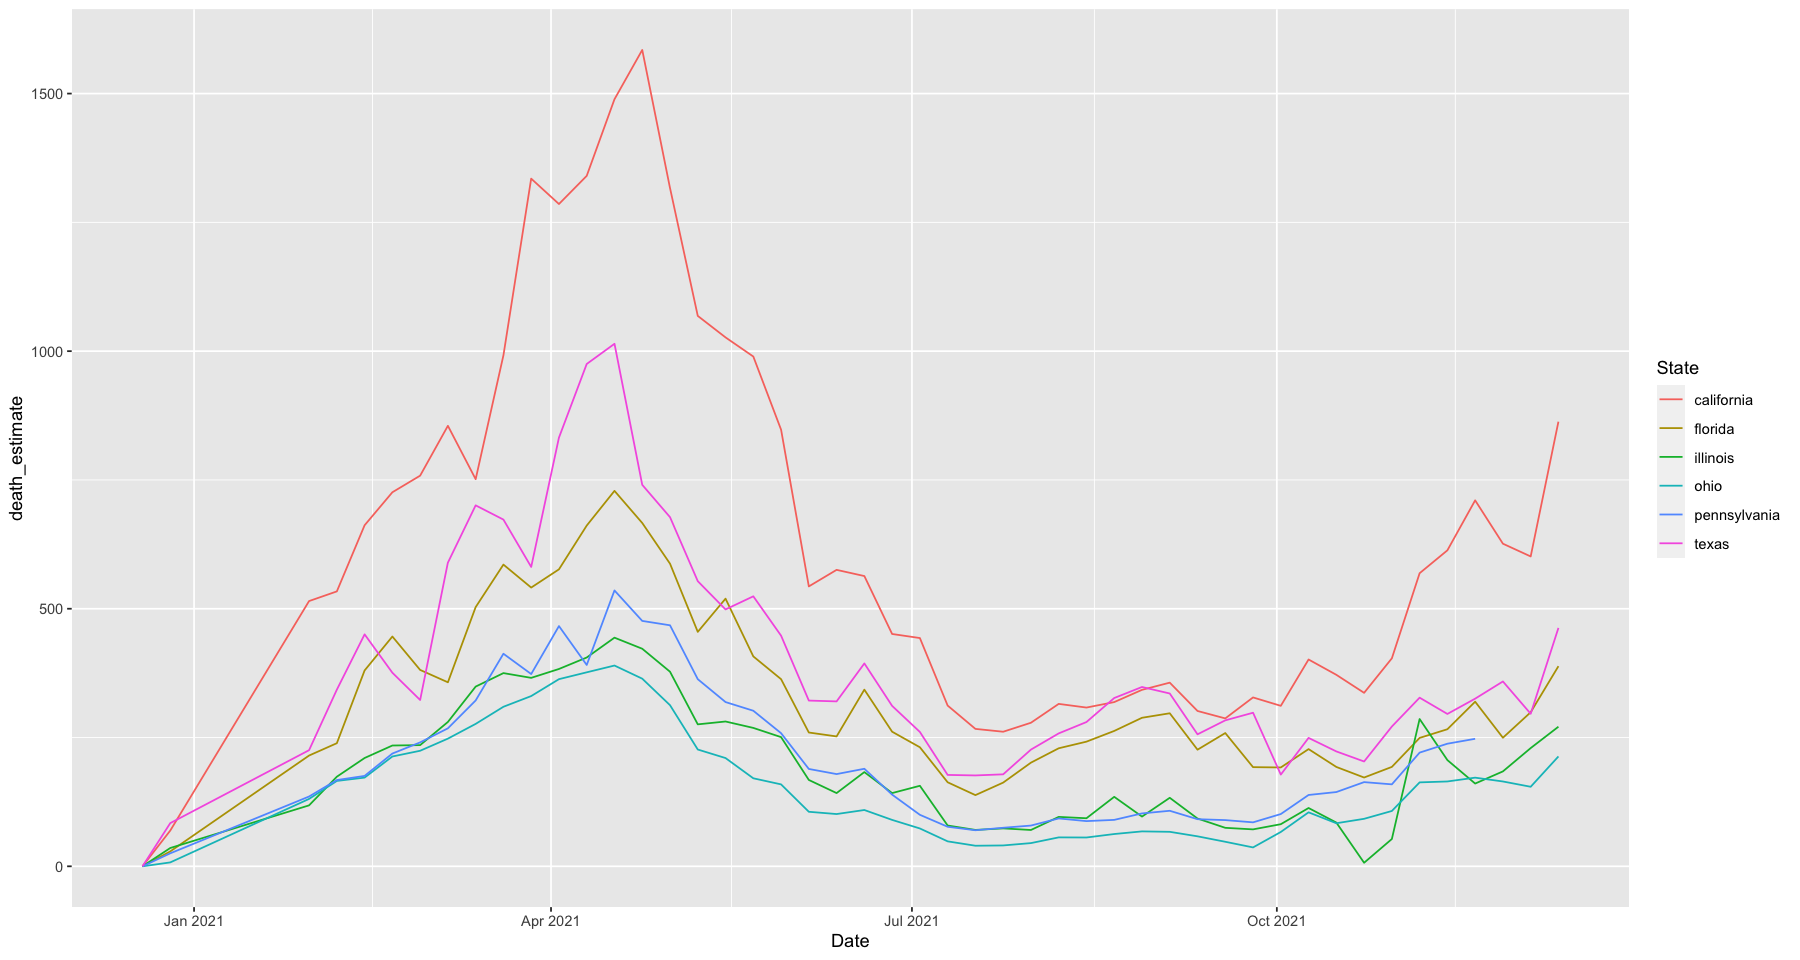

In [227]:
options(repr.plot.width=15, repr.plot.height=8)
c = ggplot(subset(df, State %in% big_states), aes(Date, death_estimate, color=State))
c + geom_line()

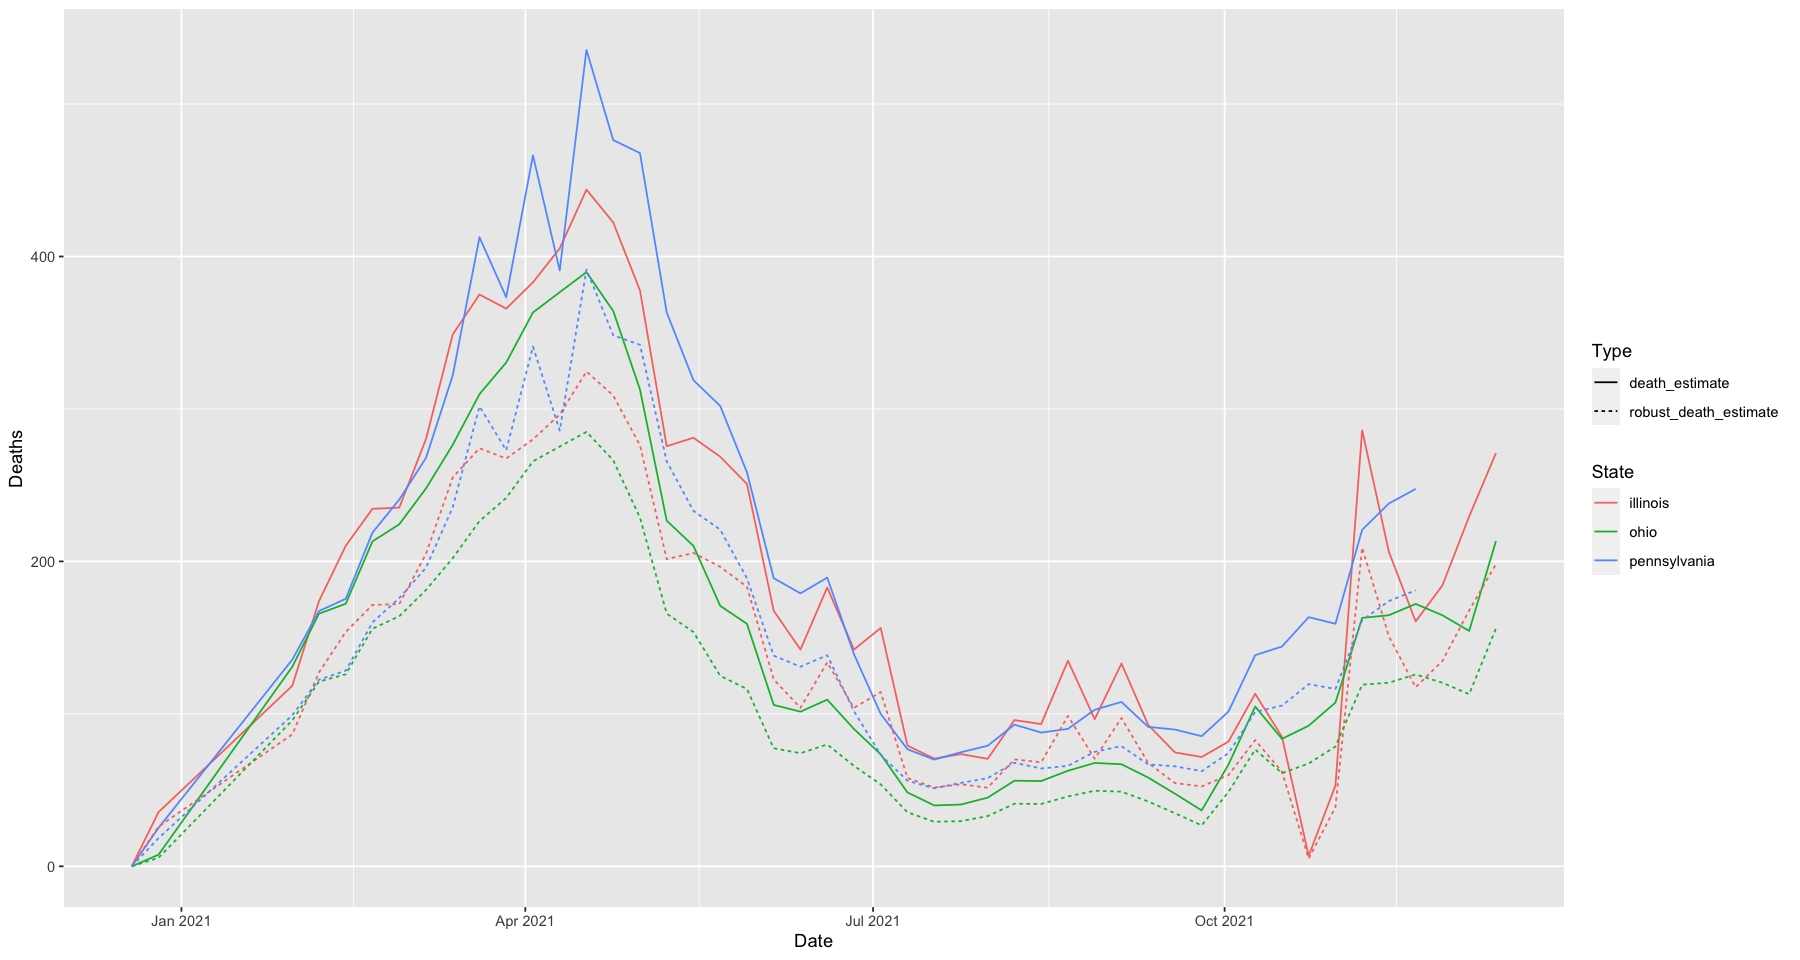

In [228]:
# Compare L1 with L2 fits in big states
pivot = pivot_longer(df, c("robust_death_estimate", "death_estimate"), values_to = "Deaths", names_to="Type")
c = ggplot(subset(pivot, State %in% big_states[1:3]), aes(Date, Deaths, color=State))
c + geom_line(aes(linetype=Type))

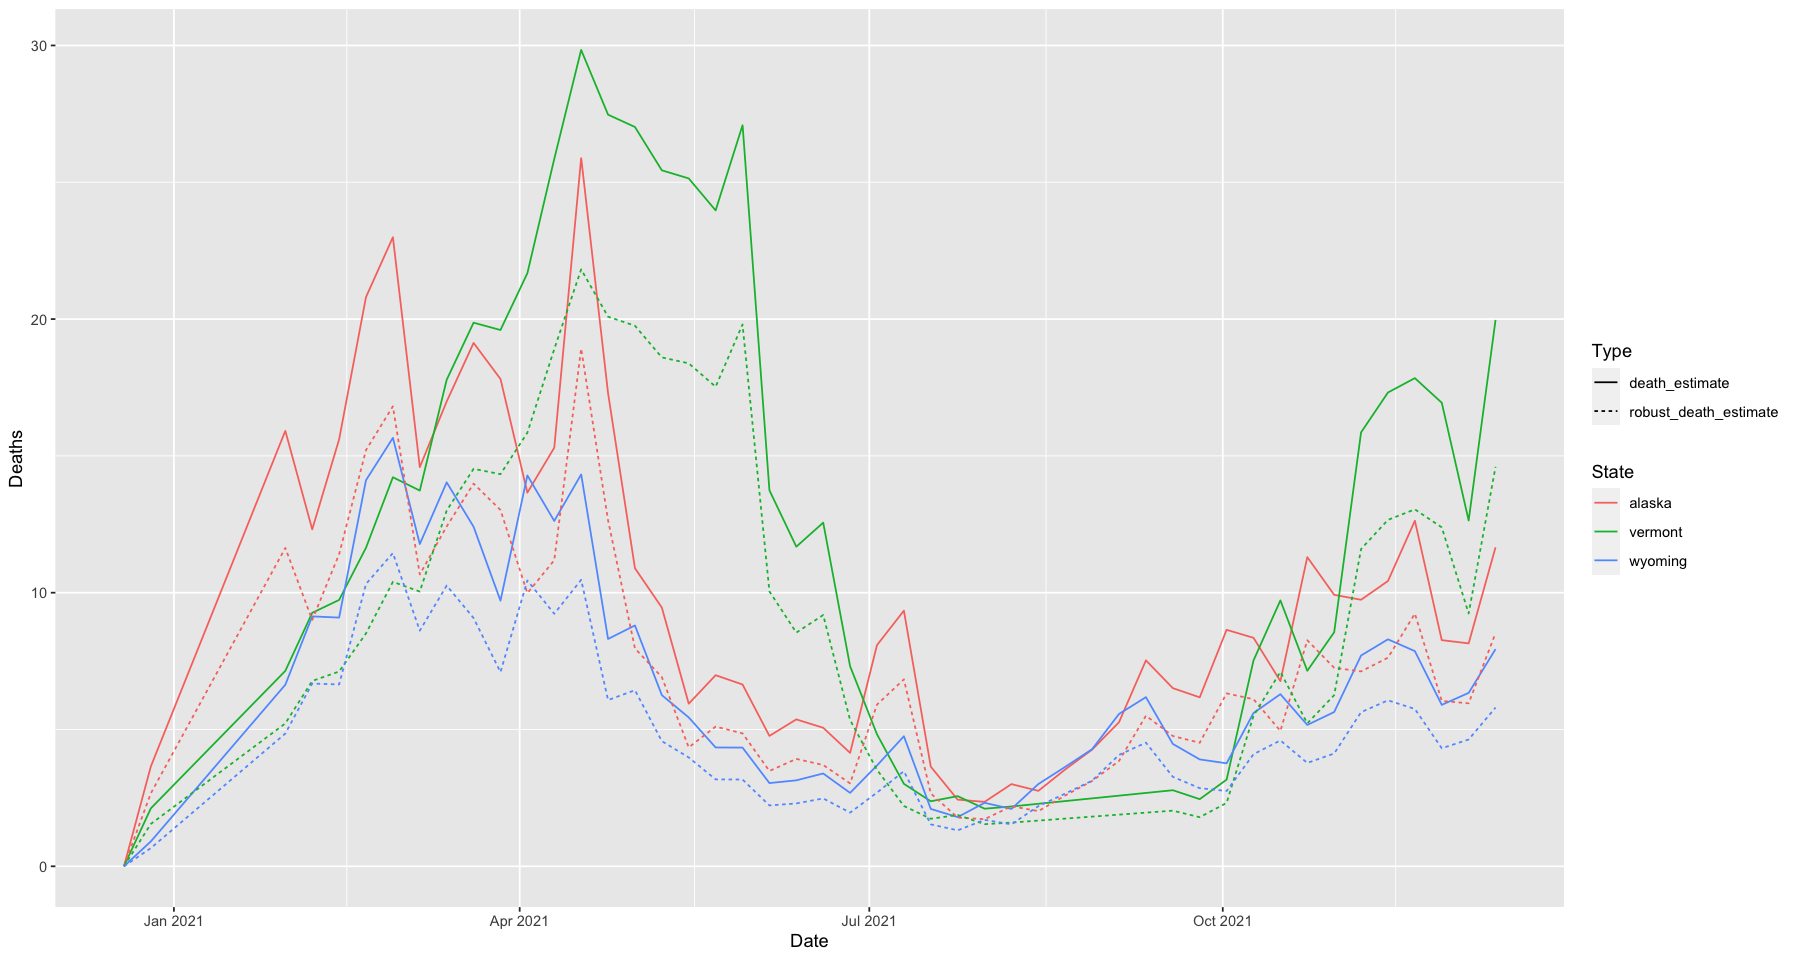

In [229]:
# Compare L1 with L2 fits in small states
pivot = pivot_longer(df, c("robust_death_estimate", "death_estimate"), values_to = "Deaths", names_to="Type")
c = ggplot(subset(pivot, State %in% small_states[1:3]), aes(Date, Deaths, color=State))
c + geom_line(aes(linetype=Type))

In [230]:
print(paste("Overall estimated # of deaths from vacc week before: (L2-norm) ", round(sum(lmfit$fit))))
print(paste("Overall estimated # of deaths from vacc week before: (L1-norm) ", round(sum(rqfit$fit))))
print(sprintf("25th and 75th quantile (Interquartile range): [%d, %d]", 
            round(sum(rqfit_low$fit)),
            round(sum(rqfit_high$fit))))
print(paste("NOT SIGNIFICANT at 5th quantile: overall estimated # of deaths from vacc week before: (L1-norm) ", round(sum(rqfit_vlow$fit))))

[1] "Overall estimated # of deaths from vacc week before: (L2-norm)  229544"
[1] "Overall estimated # of deaths from vacc week before: (L1-norm)  167841"
[1] "25th and 75th quantile (Interquartile range): [44611, 484352]"
[1] "NOT SIGNIFICANT at 5th quantile: overall estimated # of deaths from vacc week before: (L1-norm)  -69465"


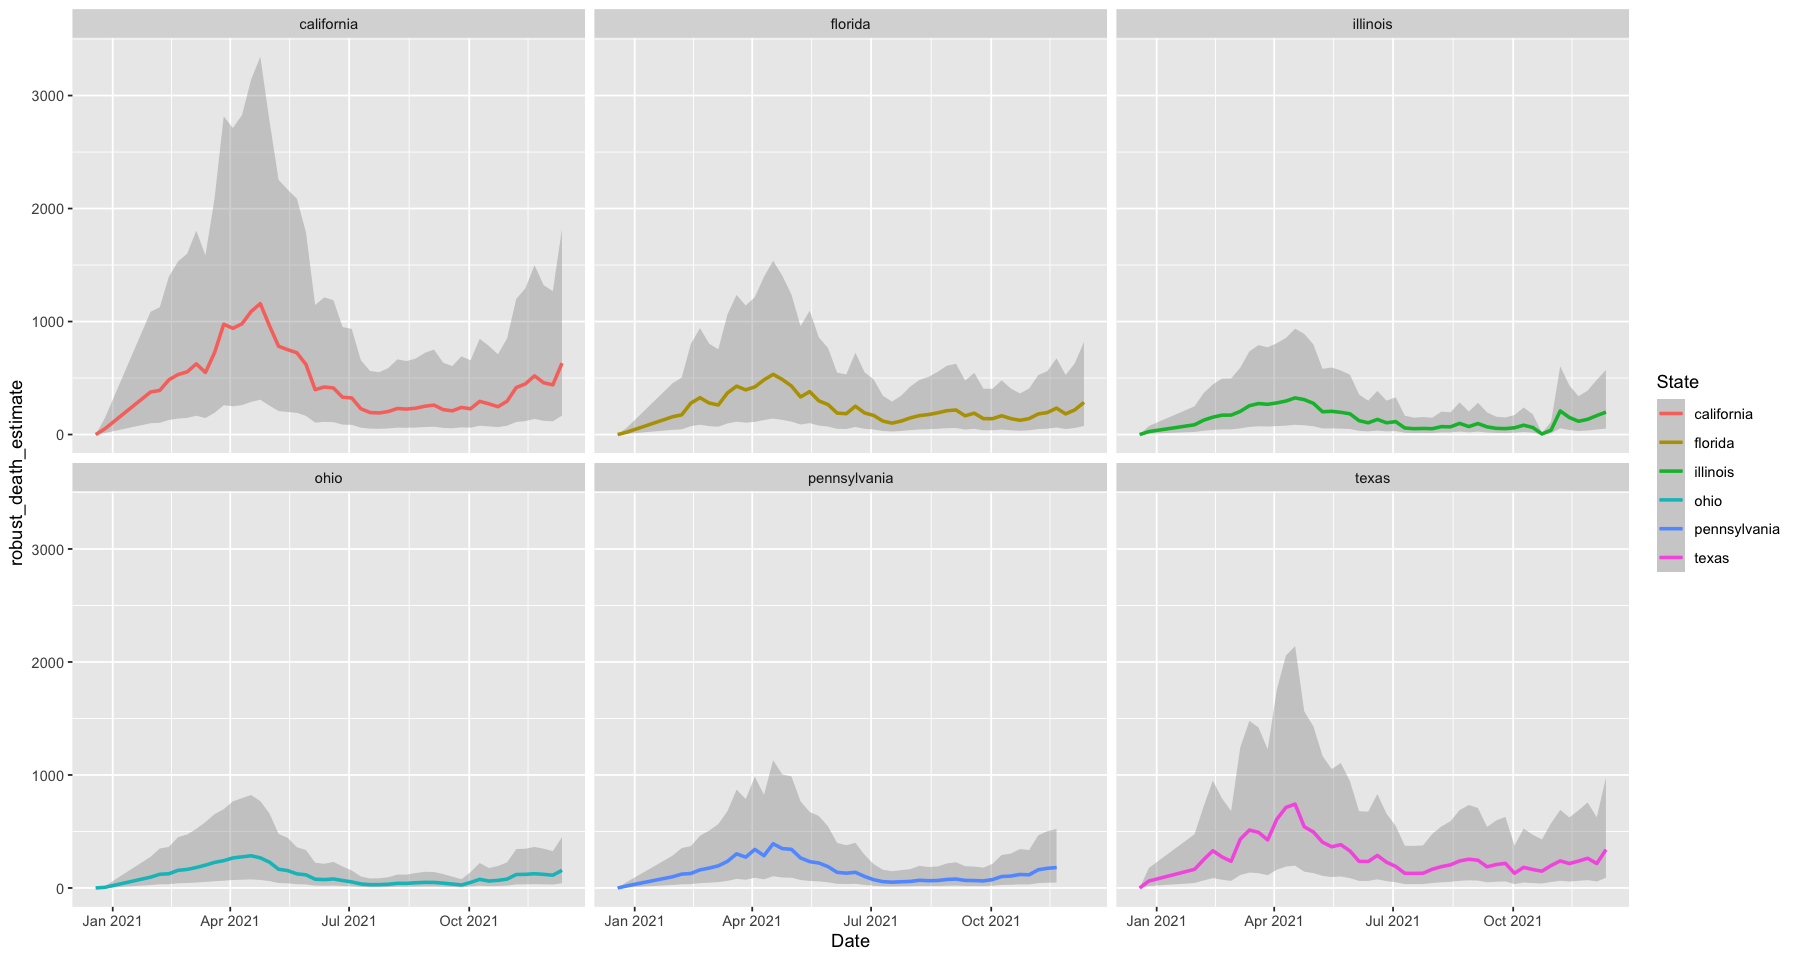

In [231]:
c = ggplot(subset(df, State %in% c(big_states)), aes(
    Date, robust_death_estimate, color=State, ymin= robust_death_estimate_low, ymax=robust_death_estimate_high))
c + geom_line() + geom_smooth(stat="identity") + facet_wrap(~State)

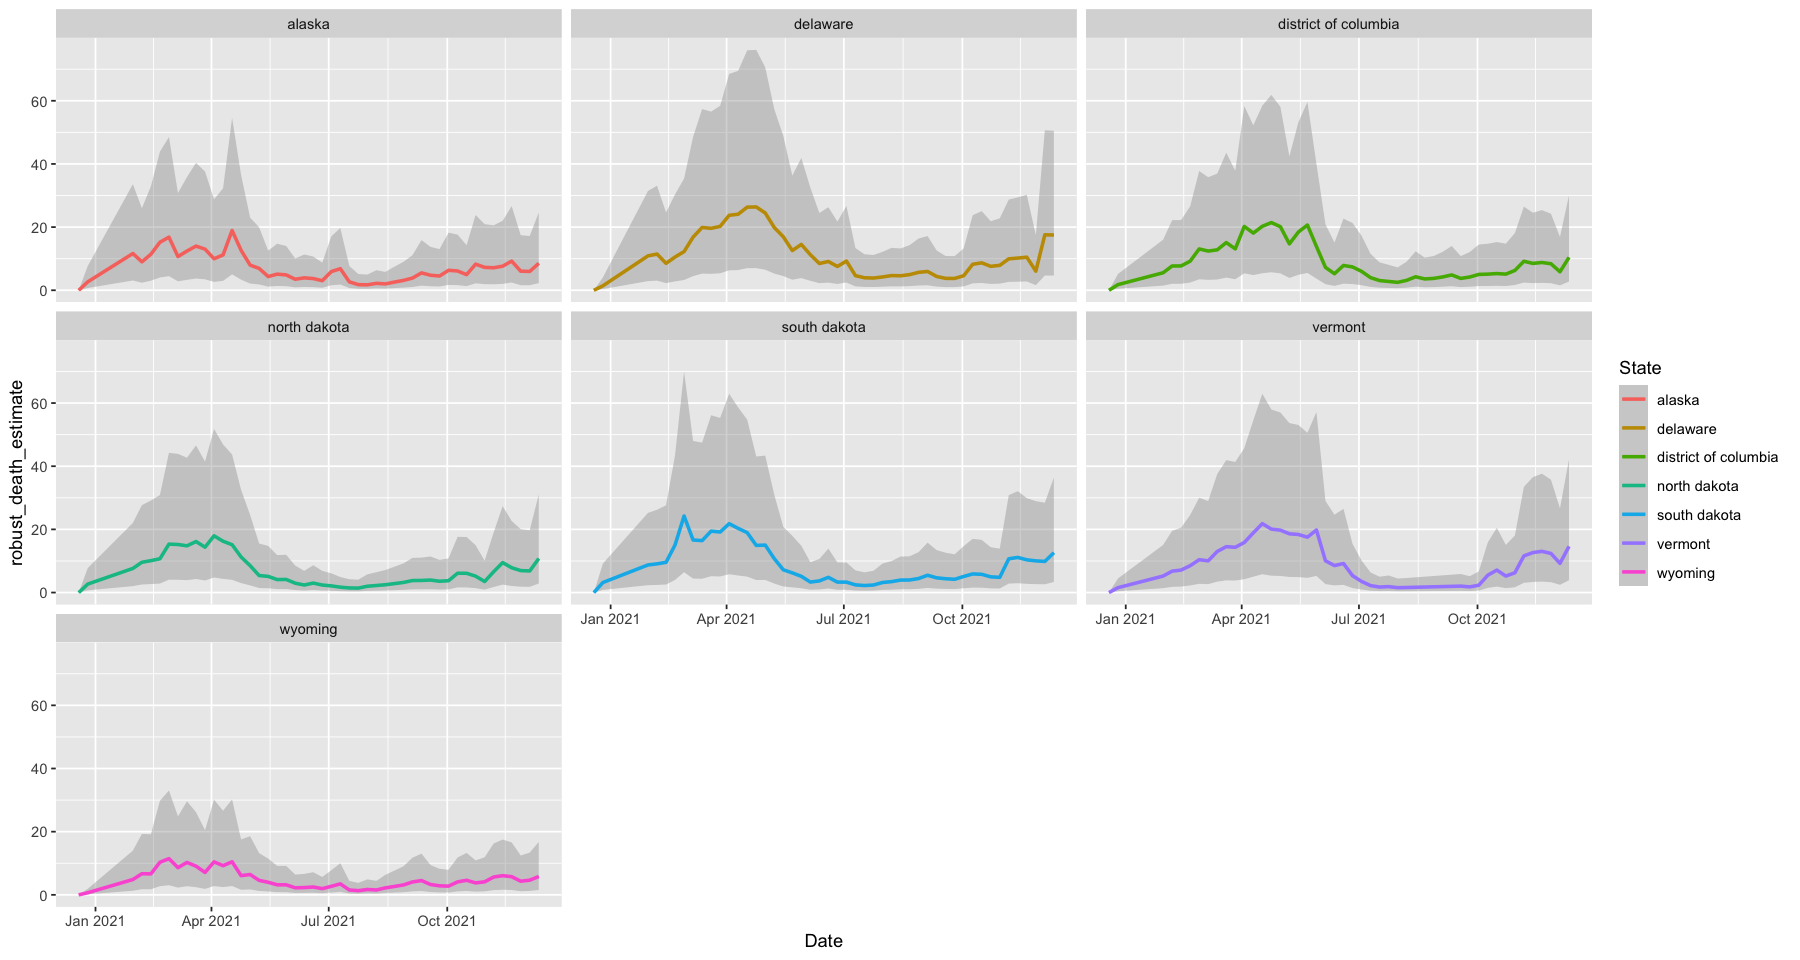

In [232]:
c = ggplot(subset(df, State %in% c(small_states)), aes(
    Date, robust_death_estimate, color=State, ymin= robust_death_estimate_low, ymax=robust_death_estimate_high))
c + geom_line() + geom_smooth(stat="identity") + facet_wrap(~State)